# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from interpolators import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
mouseline = 'line3' # Mouse line
no_slack_notify = True
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # whether to smooth the baseline with an extra moving average
ykey_postpro = Label.ZSCORE  # variable of interest for post-processing

### Derived parameters

In [4]:
dataroot = get_data_root()
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')
# Construct post-processing ID
if baseline_wlen is None:
    baseline_smoothing = False
    baseline_id = ''
else:
    baseline_id = f'w{baseline_wlen:.1f}s'
baseline_id = f'{baseline_id}_q{baseline_quantile:.2f}'
if baseline_smoothing:
    baseline_id = f'{baseline_id}_smooth'
postpro_id = f'{baseline_id}_{ykey_postpro}'.replace('/', '')
figs_suffix = f'{mouseline}_k{kalman_gain}_{postpro_id}'
si = StackInterpolator(order=0, npast=2)
kd = KalmanDenoiser(kalman_gain) if kalman_gain > 0 else NoFilter
trialavg_dir = os.path.join(trialavg_root, baseline_id, kd.code, si.code, mouseline)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{mouseline} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if not no_slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 26/05/2022 14:03:36: line3 batch notebook started on 2022-05-26 at 14:03:36


### Input summary table figure

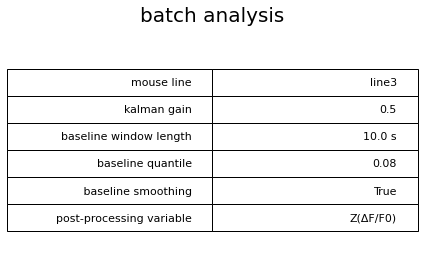

In [20]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Batch analysis')

### Load data

In [21]:

logger.info(f'loading data from {trialavg_dir}:')
data = load_datasets(trialavg_dir)
timeseries = data['timeseries']
stats = data['stats']
stats

 26/05/2022 14:18:15: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/kd_G0.5_V0.05_npad10/si_order0_npast2/line3:
 26/05/2022 14:18:15: loading timeseries data from timeseries_20191107_mouse1_region1.csv
 26/05/2022 14:18:17: loading timeseries data from timeseries_20191107_mouse1_region2.csv
 26/05/2022 14:18:17: loading timeseries data from timeseries_20191108_mouse6_region1.csv
 26/05/2022 14:18:18: loading timeseries data from timeseries_20191108_mouse6_region2.csv
 26/05/2022 14:18:19: loading timeseries data from timeseries_20191109_mouse7_region1.csv
 26/05/2022 14:18:21: loading timeseries data from timeseries_20191109_mouse7_region2.csv
 26/05/2022 14:18:22: loading timeseries data from timeseries_20191110_mouse10_region1.csv
 26/05/2022 14:18:23: loading timeseries data from timeseries_20191112_mouse12_region1.csv
 26/05/2022 14:18:23: loading timeseries data from timeseries_20191113_mouse9_region1.csv
 26/05/2022 14:18:24: loading ti

line  trial_length  duration (s)   fps  \
dataset                 ROI run                                            
20191107_mouse1_region1 1   0    line3         100.0           0.2  3.56   
                            1    line3         100.0           0.2  3.56   
                            2    line3         100.0           0.2  3.56   
                            3    line3         100.0           0.2  3.56   
                            4    line3         100.0           0.2  3.56   
...                                ...           ...           ...   ...   
20191113_mouse9_region2 685 10   line3         100.0           0.2  3.56   
                            11   line3         100.0           0.2  3.56   
                            12   line3         100.0           0.2  3.56   
                            13   line3         100.0           0.2  3.56   
                            14   line3         100.0           0.2  3.56   

                                 P (MPa)  DC (%)  run ID  I_SPPA (W/cm2)  \
dataset                 ROI run                                            
20191107_mouse1_region1 1   0       0.00    50.0   727.0        0.000000   
                            1       0.10    50.0   725.0        0.309132   
                            2       0.20    50.0   724.0        1.236530   
                            3       0.40    50.0   723.0        4.946119   
                            4       0.05    50.0   726.0        0.077283   
...                                  ...     ...     ...             ...   
20191113_mouse9_region2 685 10      0.80    40.0   903.0       19.784475   
                            11      0.80    50.0   902.0       19.784475   
                            12      0.80    60.0   908.0       19.784475   
                            13      0.80    70.0   909.0       19.784475   
                            14      0.80    80.0   910.0       19.784475   

                                 I_SPTA (W/cm2)  \
dataset                 ROI run                   
20191107_mouse1_region1 1   0          0.000000   
                            1          0.154566   
                            2          0.618265   
                            3          2.473059   
                            4          0.038642   
...                                         ...   
20191113_mouse9_region2 685 10         7.913790   
                            11         9.892238   
                            12        11.870685   
                            13        13.849133   
                            14        15.827580   

                                 peak displacement velocity (um/s)  ...  \
dataset                 ROI run                                     ...   
20191107_mouse1_region1 1   0                             0.402769  ...   
                            1                             0.346162  ...   
                            2                             0.567108  ...   
                            3                             0.479316  ...   
                            4                             0.522278  ...   
...                                                            ...  ...   
20191113_mouse9_region2 685 10                            0.369673  ...   
                            11                            0.387739  ...   
                            12                            0.366011  ...   
                            13                            0.328851  ...   
                            14                            0.569198  ...   

                                 post-stim avg Z(ΔF/F0) - pre-stim avg Z(ΔF/F0) pval  \
dataset                 ROI run                                                        
20191107_mouse1_region1 1   0                                             0.000245     
                            1                                             0.213876     
                            2                                   

### Breakdown per mouse region

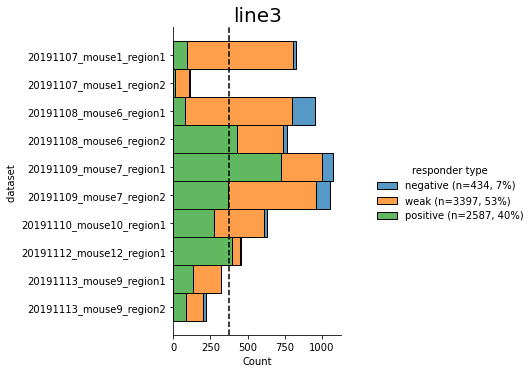

In [23]:
# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = MIN_CELL_DENSITY * area
# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count,
    title=mouseline)

### Exclude datasets with low cell count

In [10]:
# Idendify datasets with a low overall cell count
celltypes = stats.groupby([Label.DATASET, Label.ROI]).first()
cellcounts = celltypes.groupby(Label.DATASET).count().iloc[:, 0].rename('counts')
to_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()

# Exclude them
data = exclude_datasets(data.copy(), to_exclude)
timeseries = data['timeseries']
stats = data['stats']

 26/05/2022 14:07:04: excluding ['20191113_mouse9_region2', '20191113_mouse9_region1', '20191107_mouse1_region2'] datasets from analysis


### Parameter dependency curves

 26/05/2022 14:07:11: sub-indexing data...
 26/05/2022 14:07:11: filtering data...
 26/05/2022 14:07:11: cross-checking filters...
 26/05/2022 14:07:11: grouping by responder type, grouping by dataset, averaging and plotting mean diff Z(ΔF/F0) vs. P (MPa) ...
 26/05/2022 14:07:12: sub-indexing data...
 26/05/2022 14:07:12: filtering data...
 26/05/2022 14:07:12: cross-checking filters...
 26/05/2022 14:07:12: grouping by responder type, grouping by dataset, averaging and plotting mean diff Z(ΔF/F0) vs. DC (%) ...


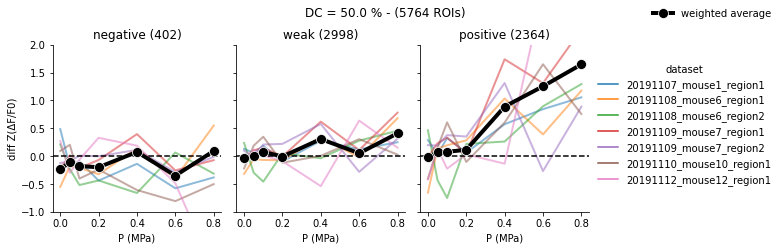

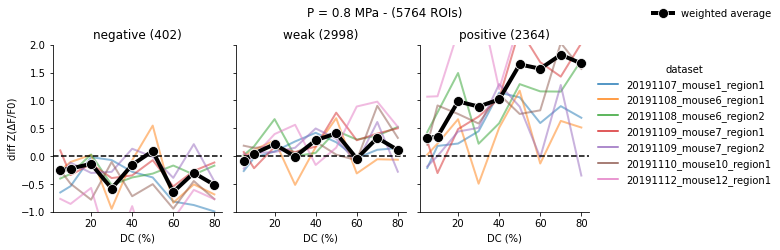

In [11]:
for pkey in [Label.P, Label.DC]:
    figs[f'{pkey}-dep {ykey_postpro}'] = plot_parameter_dependency_across_datasets(
        stats, pkey, ykey_postpro)

### Get plot-ready traces dataset

In [12]:
plt_data = get_plot_data(timeseries, stats)

 26/05/2022 14:07:38: merging timeseries and stats information...
 26/05/2022 14:08:15: adding time info to table...


### Pressure-dependent response traces

 26/05/2022 14:09:05: plotting P (MPa) dependency curves for negative responders...
 26/05/2022 14:09:06: sub-indexing data...
 26/05/2022 14:09:06: filtering data...
 26/05/2022 14:09:06: cross-checking filters...
 26/05/2022 14:09:06: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 26/05/2022 14:09:09: plotting P (MPa) dependency curves for positive responders...
 26/05/2022 14:09:10: sub-indexing data...
 26/05/2022 14:09:11: filtering data...
 26/05/2022 14:09:12: cross-checking filters...
 26/05/2022 14:09:13: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 26/05/2022 14:09:27: plotting P (MPa) dependency curves for weak responders...
 26/05/2022 14:09:28: sub-indexing data...
 26/05/2022 14:09:30: filtering data...
 26/05/2022 14:09:31: cross-checking filters...
 26/05/2022 14:09:32: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


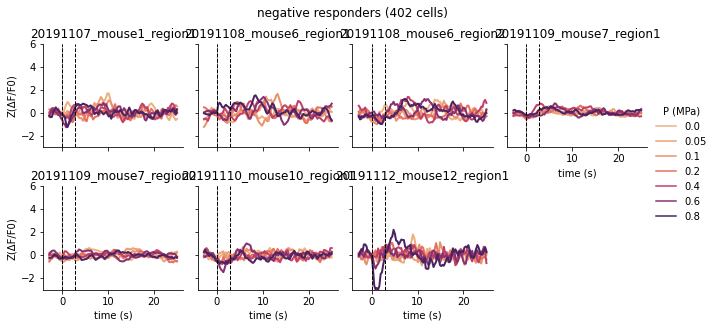

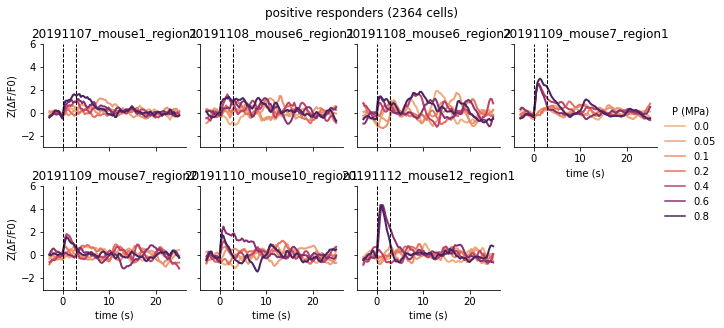

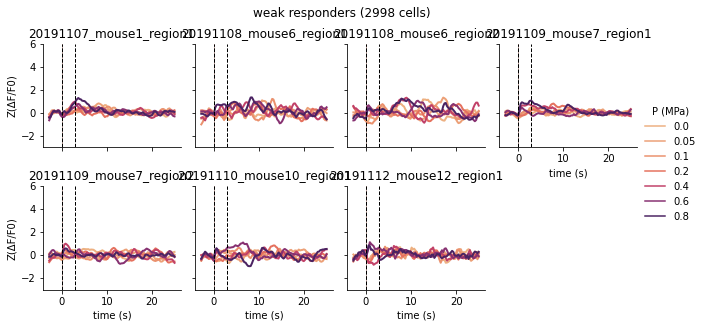

In [13]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.P))

### DC-dependent response traces

 26/05/2022 14:09:54: plotting DC (%) dependency curves for negative responders...
 26/05/2022 14:09:54: sub-indexing data...
 26/05/2022 14:09:54: filtering data...
 26/05/2022 14:09:54: cross-checking filters...
 26/05/2022 14:09:54: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 26/05/2022 14:09:58: plotting DC (%) dependency curves for positive responders...
 26/05/2022 14:09:59: sub-indexing data...
 26/05/2022 14:10:00: filtering data...
 26/05/2022 14:10:01: cross-checking filters...
 26/05/2022 14:10:02: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 26/05/2022 14:10:19: plotting DC (%) dependency curves for weak responders...
 26/05/2022 14:10:20: sub-indexing data...
 26/05/2022 14:10:22: filtering data...
 26/05/2022 14:10:22: cross-checking filters...
 26/05/2022 14:10:24: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


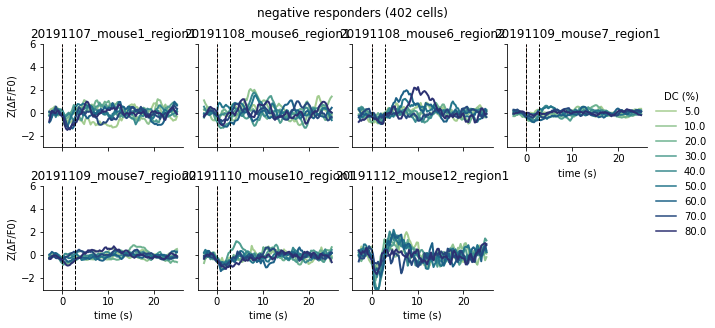

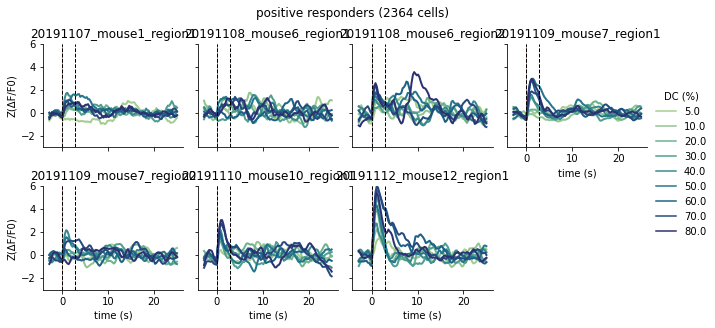

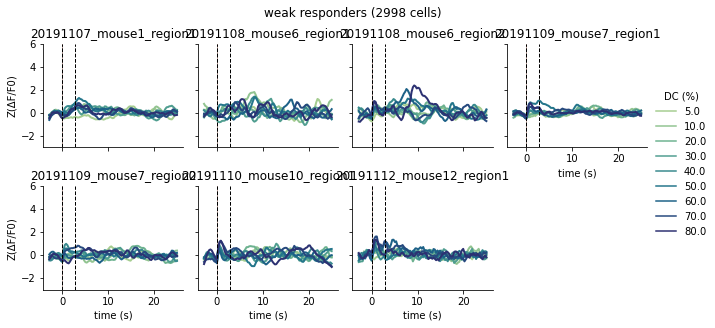

In [14]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.DC))

### Average response traces across datasets (weighted)

 26/05/2022 14:10:47: sub-indexing data...
 26/05/2022 14:10:50: filtering data...
 26/05/2022 14:10:52: cross-checking filters...
 26/05/2022 14:10:54: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 26/05/2022 14:11:23: sub-indexing data...
 26/05/2022 14:11:27: filtering data...
 26/05/2022 14:11:28: cross-checking filters...
 26/05/2022 14:11:31: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


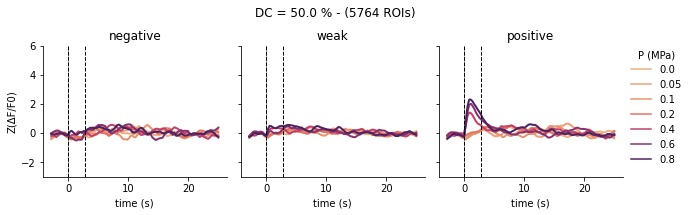

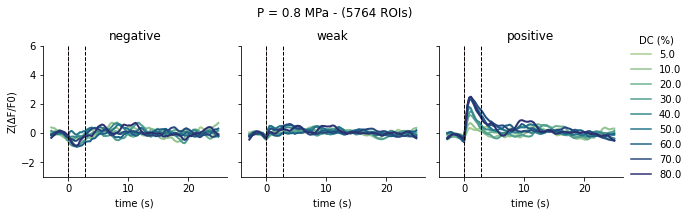

In [15]:
# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - weighted'] = plot_responses_across_datasets(
        plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Average response traces across datasets (non-weighted)

 26/05/2022 14:12:07: checking for run order consistency across datasets...
 26/05/2022 14:12:10: computing average traces per dataset and condition...
 26/05/2022 14:12:15: sub-indexing data...
 26/05/2022 14:12:15: filtering data...
 26/05/2022 14:12:15: cross-checking filters...
 26/05/2022 14:12:15: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 26/05/2022 14:12:15: sub-indexing data...
 26/05/2022 14:12:15: filtering data...
 26/05/2022 14:12:15: cross-checking filters...
 26/05/2022 14:12:15: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


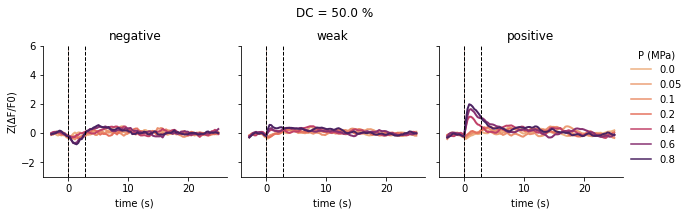

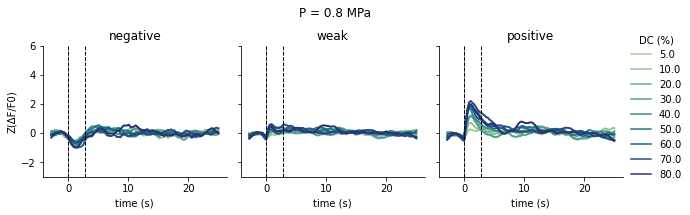

In [16]:
# Check run order consistency across datasets
logger.info('checking for run order consistency across datasets...')
params_per_run = plt_data.groupby([Label.DATASET, Label.RUN]).first()[[Label.P, Label.DC]]
for k in params_per_run:
    sum_of_stds = params_per_run[k].unstack().std().sum()
    if sum_of_stds > 1e-12:
        logger.error('variation in run orders across dataset')

# Group data by mouse-region, response type, run and frame -> average
logger.info('computing average traces per dataset and condition...')
avg_plt_data = plt_data.groupby(
    [Label.DATASET, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR, Label.TIME])

# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - nonweighted'] = plot_responses_across_datasets(
        avg_plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Save figures

In [17]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 26/05/2022 14:13:31: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.05.26/figs_line3_k0.5_w10.0s_q0.08_smooth_Z(ΔFF0).pdf:


100%|██████████| 13/13 [00:02<00:00,  6.41it/s]


### Notify upon completion

In [18]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if not no_slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 26/05/2022 14:13:36: line3 batch notebook completed in 0:09:59.401281 s
